## Building Autoencoders in Keras

### Agenda

In this tutorial, we will answer some common questions about autoencoders, and we will cover code examples of the following models:

1. simple autoencoder based on a fully-connected layer
2. sparse autoencoder
3. deep fully-connected autoencoder
4. deep convolutional autoencoder
5. image denoising model
6. sequence-to-sequence autoencoder
7. variational autoencoder

## Introduction

### What are autoencoders?

Autoencoder is a neural network designed to **learn an identity function in an unsupervised way to reconstruct the original input while compressing the data in the process so as to discover a more efficient and compressed representation.**

It consists of two networks:
- **Encoder network:** It translates the original high-dimension input into the latent low-dimensional code. The input size is larger than the output size.
- **Decoder network:** The decoder network recovers the data from the code, likely with larger and larger output layers.

<img src="00a_autoencoder.png" width="800">

"Autoencoding" is a data compression algorithm where the **compression and decompression functions** are 
- data-specific, 
- lossy, and 
- learned automatically from examples rather than engineered by a human. 

Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) **Autoencoders are data-specific**, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. 

An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) **Autoencoders are lossy,** which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) **Autoencoders are learned automatically from data examples**, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.


To build an autoencoder, you need three things: 
 - an encoding function, 
 - a decoding function, 
 - and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). 

The encoder and decoder will be chosen to be **parametric functions** (typically neural networks), and to be **differentiable with respect to the distance function**, so the parameters of the encoding/decoding functions can be optimize to **minimize the reconstruction loss**, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

### Are they good at data compression?

**Usually, not really.** In picture compression for instance, it is pretty difficult to train an autoencoder that does a better job than a basic algorithm like JPEG, and typically the only way it can be achieved is by restricting yourself to a very specific type of picture (e.g. one for which JPEG does not do a good job). 

The fact that autoencoders are data-specific makes them generally impractical for real-world data compression problems: **you can only use them on data that is similar to what they were trained on**, and making them more general thus requires lots of training data. But future advances might change this, who knows.

### What are autoencoders good for?

They are rarely used now in practical applications. 

In 2012 they briefly found an **application in greedy layer-wise pretraining for deep convolutional neural networks** , but this quickly fell out of fashion as we started realizing that better random weight initialization schemes were sufficient for training deep networks from scratch. 

In 2014, batch normalization started allowing for even deeper networks, and from late 2015 we could train arbitrarily deep networks from scratch using residual learning.

Today two interesting practical applications of autoencoders are **data denoising** (which we feature later in this post), and **dimensionality reduction for data visualization**. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a **good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane**. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on Github. Otherwise scikit-learn also has a simple and practical implementation.

### So what's the big deal with autoencoders?

Otherwise, one reason why they have attracted so much research and attention is because they have long been thought to be a **potential avenue for solving the problem of unsupervised learning, i.e. the learning of useful representations without the need for labels.**

Then again, autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), **they are a self-supervised technique**, a specific instance of supervised learning where the targets are generated from the input data. 

In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here. 

At this point there is significant evidence that focusing on the reconstruction of a picture at the pixel level, for instance, is not conductive to learning interesting, abstract features of the kind that label-supervized learning induces (where targets are fairly abstract concepts "invented" by humans such as "dog", "car"...). In fact, one may argue that the best features in this regard are those that are the worst at exact input reconstruction while achieving high performance on the main task that you are interested in (classification, localization, etc).

## Applications

###  Data compression via autoencoders

Suppose that I would like to write a program to send some data from my cellphone to the cloud. Since I want to limit my network usage, I will optimize every bit of data that I am going to send. The data is a collection of data points, each has two dimensions. A sample of my data look like the following:

<img src="00_mobile_data.png" width="400">

Here, the red crosses are my data points, the horizontal axis is the value of the first dimension and the vertical axis is the value of the second dimension.

Upon visualization, I notice is that the value of the second dimension is approximately twice as much as that of the first dimension. Given this observation, **we can send only the first dimension of every data point to the cloud**. Then at the cloud, we can compute the value of the second dimension by doubling the value of the first dimension. 

This requires some computation, and the compression is lossy, but it reduces the network traffic by 50%. And since network traffic is what I try to optimize, this idea seems reasonable

So far this method is achieved via visualization, but the bigger question is can we do this more system-atically for high-dimensional data? 

More formally, suppose we have a set of data points {x(1), x(2), ..., x(m)} where each data point has many dimensions. The question becomes whether there is a general way to map them to another set of data points {z(1),z(2),...,z(m)}, where z’s have lower dimensionality than x’s and z’s can faithfully reconstruct x’s.

To answer this, notice that in the above process of sending data from my cellphone to the cloud has three steps:
 1. Encoding: in my cellphone, map my data x
 2. Sending: send z(i) to the cloud.
 3. Decoding: in the cloud, map from my compressed data z(i) back to x ̃(i), which approximates the original data.

Functions which are used looks like

<img src="01_mobile_data_equation.png" width="400">

If x(i) is a two-dimensional vector, it may be possible to visualize the data to find W1,b1 and W2,b2 analytically as the experiment above suggested. Most often, it is difficult to find those matrices using visualization, so we will have to **rely on gradient descent.**

As our goal is to have x ̃(i) to approximate x(i), we can set up the following **objective function, which is the sum of squared differences between x ̃(i) and x(i):**

<img src="02_mobile_data_loss.png" width="400">

which can be minimized using stochastic gradient descent.

This particular architecture is also known as a **linear autoencoder**, which is shown in the following
network architecture:

<img src="03_Mobile_data_network1.png" width="400">

In the above figure, we are trying to map data from 4 dimensions to 2 dimensions using a neural network with one hidden layer. **The activation function of the hidden layer is linear and hence the name linear autoencoder.**

The above network uses the linear activation function and works for the case that the data lie on a linear surface. 

**If the data lie on a nonlinear surface, it makes more sense to use a nonlinear autoencoder**, e.g., one that looks like following :

<img src="04_mobile_data_network2.png" width="400">

**If the data is highly nonlinear, one could add more hidden layers to the network to have a deep autoencoder.**

### Autoencoders as an initialization method

Autoencoders could be used as a way to “pretrain” neural networks. Why? The reason is that training very deep neural networks is difficult:

- The magnitudes of gradients in the lower layers and in higher layers are different
- The landscape or curvature of the objective function is difficult for stochastic gradient descent to find a good local optimum
- Deep networks have many parameters, which can remember training data and do not generalize well

The goal of pretraining is to address the above problems. With pretraining, the process of training a deep
network is divided in a sequence of steps:

- **Pretraining step:** train a sequence of shallow autoencoders, greedily one layer at a time, using unsupervised data,
- **Fine-tuning step 1:** train the last layer using supervised data,
- **Fine-tuning step 2:** use backpropagation to fine-tune the entire network using supervised data


Suppose I would like to train a relatively deep network of two hidden layers to classify some data. The parameters of the first two hidden layers are W1 and W2 respectively. Such network can be pretrained by a sequence of two autoencoders, in the following manner:

<img src="05_initializing.png" width="800">

More concretely, to train the red neurons, we will **train an autoencoder that has parameters W1 and W1'.**

After this, we will **use W1 to compute the values for the red neurons for all of our data, which will then
be used as input data to the subsequent autoencoder.**

The **parameters of the decoding process W1′ will be discarded**

The s**ubsequent autoencoder uses the values for the red neurons as inputs, and trains an autoencoder to predict those values by adding a decoding layer with parameters W2'**.

### Autoencoders as a Denoising method

Denoising Method is the process of removing noise from a signal. 

The term “noise” here could be:
- Produced by a faulty or poor quality image sensor
- Random variations in brightness or color
- Quantization noise
- Artifacts due to JPEG compression
- Image perturbations produced by an image scanner or threshold post-processing
- Poor paper quality (crinkles and folds) when trying to perform OCR

you should think of noise as anything that could be removed by a **really good pre-processing filter**.

Our goal is to train an autoencoder to perform such pre-processing — we call such **models denoising autoencoders**

<img src="06_Denoise_autoencoder.png" width="800">

<img src="06a_Denoising_autoencoder.png" width="800">

Denoising autoencoders are an extension of simple autoencoders; however, it’s worth noting that denoising autoencoders were **not originally meant to automatically denoise an image.**

Instead, the denoising autoencoder procedure was invented to help:
- The hidden layers of the autoencoder learn more robust filters
- Reduce the risk of overfitting in the autoencoder
- Prevent the autoencoder from learning a simple identify function

Researchers found that they could improve the **robustness of their internal layers** (i.e., latent-space representation) by **purposely introducing noise to their signal.**

**Noise was stochastically (i.e., randomly) added to the input data, and then the autoencoder was trained to recover the original, nonperturbed signal.**

**In order to force the hidden layer to discover more robust features and prevent it from simply learning the identity, we train the autoencoder to reconstruct the input from a corrupted version of it.**

The denoising auto-encoder is a stochastic version of the auto-encoder. 

Intuitively, a denoising auto-encoder does two things: 
- try to **encode the input** (preserve the information about the input), 
- and try to **undo the effect of a corruption process** stochastically applied to the input of the auto-encoder. This can only be done by capturing the statistical dependencies between the inputs. 

The denoising auto-encoder can be understood from different perspectives **(the manifold learning perspective, stochastic operator perspective, bottom-up – information theoretic perspective, top-down – generative model perspective)**

### Other Types of Autoencoders

#### Sparse Autoencoder

Sparse Autoencoder applies a **“sparse” constraint on the hidden unit activation to avoid overfitting and improve robustness.** It forces the model to **only have a small number of hidden units being activated at the same time**, or in other words, one hidden neuron should be inactivate most of time

This constraint is achieved by adding a penalty term into the loss function. 

**K-Sparse AutoEncoders**

the sparsity is enforced by only **keeping the top k highest activations in the bottleneck layer with linear activation function.**


<img src="07_Ksparse.png" width="800">

#### Contractive Autoencoder

Similar to sparse autoencoder, Contractive Autoencoder (Rifai, et al, 2011) **encourages the learned representation to stay in a contractive space for better robustness**

It **adds a term in the loss function to penalize the representation being too sensitive to the input**, and thus improve the robustness to small perturbations around the training data points.

The sensitivity is measured by the Frobenius norm of the Jacobian matrix of the encoder activations with respect to the input:

### Variational Autoencoders

**VAE is a directed Generative Model.** It has emerged as a popular unsupervised Learning method.

Autoencoder that **learns a latent variable model for its input data**. So instead of letting your neural network learn an arbitrary function, you are **learning the parameters of a probability distribution modeling your data**. 

If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

A Generative model is able to generate samples like those in the training data. In Generative model, any of the sample can be decoded into reasonable image of the original image.

VAE has both observed and latent variables. It gives us a latent space to sample data from. 

Example - observed variable can be an image (eg. human face) and latent variables can be the factors that explain features of face- happy or sad, male or female

**A VAE models a data distribution using a collection of independent latent variables.**
- It is a deep learning technique for learning latent representation
- A hybrid of deep learning and variational inference


**Optimization Objective: Autoencoding**

Fit a q(z∣x) to map x into a useful latent space z from which we can reconstruct x via p(x∣z).
- Reminiscent of auto-encoder neural networks
- An auto-encoder is a pair of neural networks f,g that are composed as x’=f(g(x))

They are trained to minimize reconstruction error ∥x’−x∥
In practice, g(x) learns to embed x in a latent space that often has an intuitive interpretation


**Steps:**
- First, an encoder network **turns the input samples x into two parameters in a latent space**, which we will note z_mean and z_log_sigma.
- Then, we **randomly sample similar points z from the latent normal distribution** that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. 
- Finally, a **decoder network maps these latent space points back to the original input data**.
- train the model using the end-to-end model, with a custom loss function

The parameters of the model are trained via **two loss functions:**
- a **reconstruction loss** forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), 
- and the **KL divergence between the learned latent distribution and the prior distribution**, acting as a regularization term. 


<img src="08c_VAE.png" width="800">

**The reparameterization trick**

optimizing our objective requires a good estimate of the gradient. The main technical contribution of VAE is a **low- variance gradient estimator** based on the reparametrization trick

- Given a random variable z with one distribution we can create another random variable X=g(z) with a completely different distribution

**Gaussian variables** provide the simplest example of the reparametrization trick

Instead of writing z ∼ qμ,σ(z)=N(μ,σ), we write 
    z =gμ,σ(ε) = μ + ε⋅σ
    where ε∼N(0,1)
    
It is easy to check that the two ways of expressing the random variable z lead to the same distribution.

Advantage is reduced variance. 


<img src="08d_VAE.png" width="800">

**Use of VAE**
1. Draw Images
2. State-of-the-art results in semi-supervised learning
3. Interpolate between sentences

Variational autoencoder p(x|z)p(z) applied to face images (modeled by x)

The learned latent space z can be used to interpolate between facial expressions

<img src="08_VAE.png" width="800">

<img src="08b_VAE.png" width="800">

## Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [67]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


Let's also create a separate encoder model:

In [68]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

As well as the decoder model:

In [69]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [70]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [71]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

In [72]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:

In [73]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.3476 - val_loss: 0.2704
Epoch 2/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2629 - val_loss: 0.2512
Epoch 3/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2396 - val_loss: 0.2261
Epoch 4/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2183 - val_loss: 0.2087
Epoch 5/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.2042 - val_loss: 0.1972
Epoch 6/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1942 - val_loss: 0.1886
Epoch 7/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1864 - val_loss: 0.1814
Epoch 8/50
60000/60000 [==============================] - 1s 13us/step - loss: 0.1797 - val_loss: 0.1750
Epoch 9/50
60000/60000 [==============================] - 1s 12us/step - loss: 0.1737 - val_loss: 0.1694
Epoch

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [74]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [76]:
print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 32)
(10000, 784)


In [77]:
encoded_imgs.mean()

7.630978

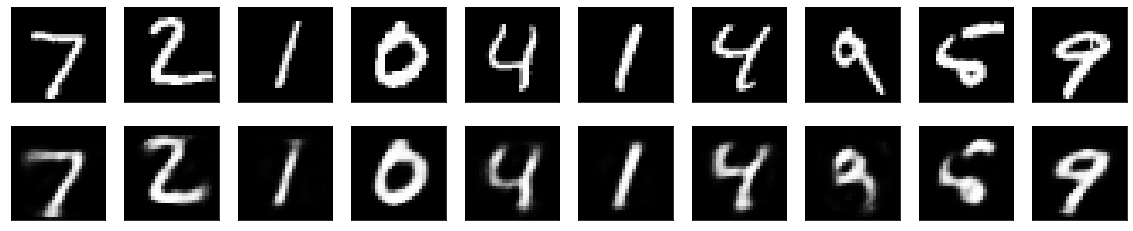

In [78]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

### Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). 

But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [118]:
import keras
keras.backend.clear_session()

In [119]:
import tensorflow as tf

In [158]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-7))(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)


In [159]:
autoencoder.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

Here's a visualization of our new results:

In [160]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [161]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [162]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [163]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [164]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


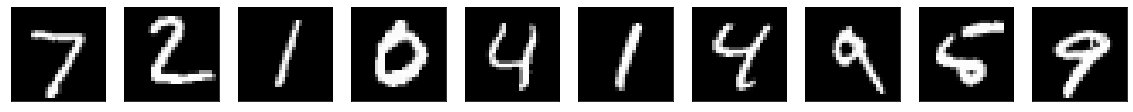

In [165]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    #plt.imshow(x_train[i].reshape(28, 28))
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [166]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 15us/step - loss: 0.3758 - val_loss: 0.2874
Epoch 2/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2815 - val_loss: 0.2739
Epoch 3/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2657 - val_loss: 0.2557
Epoch 4/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2485 - val_loss: 0.2396
Epoch 5/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2345 - val_loss: 0.2272
Epoch 6/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2236 - val_loss: 0.2176
Epoch 7/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.2148 - val_loss: 0.2096
Epoch 8/100
60000/60000 [==============================] - 1s 14us/step - loss: 0.2074 - val_loss: 0.2029
Epoch 9/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.2014 - val_loss: 0.1

60000/60000 [==============================] - 1s 14us/step - loss: 0.1422 - val_loss: 0.1403
Epoch 78/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.1420 - val_loss: 0.1402
Epoch 79/100
60000/60000 [==============================] - 1s 17us/step - loss: 0.1419 - val_loss: 0.1400
Epoch 80/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.1417 - val_loss: 0.1398
Epoch 81/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.1415 - val_loss: 0.1397
Epoch 82/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.1414 - val_loss: 0.1395
Epoch 83/100
60000/60000 [==============================] - 1s 16us/step - loss: 0.1412 - val_loss: 0.1393
Epoch 84/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.1410 - val_loss: 0.1392
Epoch 85/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.1409 - val_loss: 0.1390
Epoch 86/100
60000/60000 [========================

In [167]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 32)
(10000, 784)


In [168]:
print(encoded_imgs.mean())
output = "{:.7f}".format(encoded_imgs.mean())
print(output)

1.630668
1.6306680


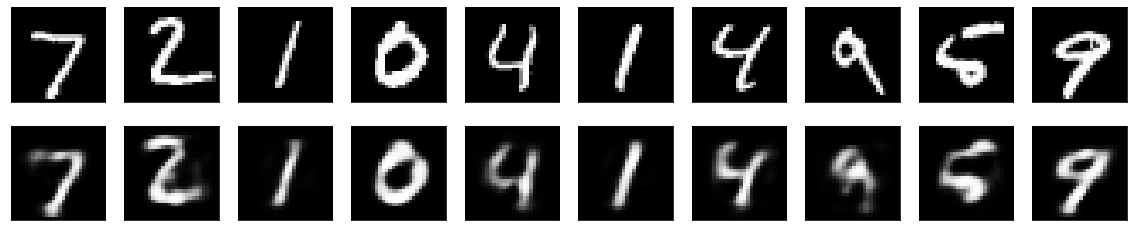

In [169]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 1.630668 (over our 10,000 test images), whereas with the previous model the same quantity was 7.63. So our new model yields encoded representations that are 5 times sparser.

## Deep autoencoder

In [197]:
import keras
keras.backend.clear_session()

In [198]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               1011

In [199]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


In [201]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(32,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
decode_val=decoder_layer(encoded_input)

decoder_layer = autoencoder.layers[-2]
decode_val=decoder_layer(decode_val)

decoder_layer = autoencoder.layers[-1]
decode_val=decoder_layer(decode_val)

decoder = Model(encoded_input, decode_val)

decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


In [202]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.3395 - val_loss: 0.2632
Epoch 2/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.2576 - val_loss: 0.2522
Epoch 3/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.2444 - val_loss: 0.2381
Epoch 4/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.2288 - val_loss: 0.2159
Epoch 5/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.2125 - val_loss: 0.2084
Epoch 6/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.2026 - val_loss: 0.1940
Epoch 7/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1909 - val_loss: 0.1853
Epoch 8/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1829 - val_loss: 0.1775
Epoch 9/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.1765 - val_loss: 0.1

60000/60000 [==============================] - 2s 31us/step - loss: 0.1041 - val_loss: 0.1027
Epoch 78/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1037 - val_loss: 0.1029
Epoch 79/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.1035 - val_loss: 0.1021
Epoch 80/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.1033 - val_loss: 0.1044
Epoch 81/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1032 - val_loss: 0.1002
Epoch 82/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1030 - val_loss: 0.1034
Epoch 83/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1026 - val_loss: 0.1016
Epoch 84/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1025 - val_loss: 0.1024
Epoch 85/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1022 - val_loss: 0.1022
Epoch 86/100
60000/60000 [========================

After 100 epochs, it reaches a train and test loss of ~0.097, a bit better than our previous models. Our reconstructed digits look a bit better too:

In [203]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

print(encoded_imgs.shape)
print(decoded_imgs.shape)

(10000, 32)
(10000, 784)


In [204]:
encoded_imgs.mean()

5.0886264

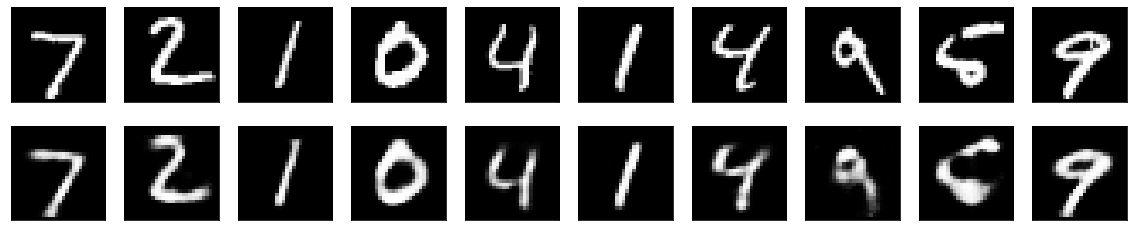

In [205]:
# encode and decode some digits
# note that we take them from the *test* set
#encoded_imgs = autoencoder.predict(x_test)
#decoded_imgs = autoencoder.predict(x_test)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [206]:
#Deep convolutional auto encoders
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [209]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0   

In [207]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [56]:
#Run the below command in terminal
#tensorboard --logdir='/Users/rajeevsinghal/Work/Learning/Data Science/DS_Topics'

In [208]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                #callbacks=[TensorBoard(log_dir='/Users/rajeevsinghal/Work/Learning/Data Science/DS_Topics')]
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 38s 633us/step - loss: 0.2078 - val_loss: 0.1649
Epoch 2/50
60000/60000 [==============================] - 37s 616us/step - loss: 0.1568 - val_loss: 0.1467
Epoch 3/50
60000/60000 [==============================] - 37s 615us/step - loss: 0.1430 - val_loss: 0.1357
Epoch 4/50
60000/60000 [==============================] - 38s 636us/step - loss: 0.1349 - val_loss: 0.1286
Epoch 5/50
60000/60000 [==============================] - 38s 626us/step - loss: 0.1290 - val_loss: 0.1265
Epoch 6/50
60000/60000 [==============================] - 38s 633us/step - loss: 0.1249 - val_loss: 0.1195
Epoch 7/50
60000/60000 [==============================] - 37s 625us/step - loss: 0.1217 - val_loss: 0.1204
Epoch 8/50
60000/60000 [==============================] - 38s 628us/step - loss: 0.1196 - val_loss: 0.1177
Epoch 9/50
60000/60000 [==============================] - 38s 633us/step - loss: 0.1176 - val_

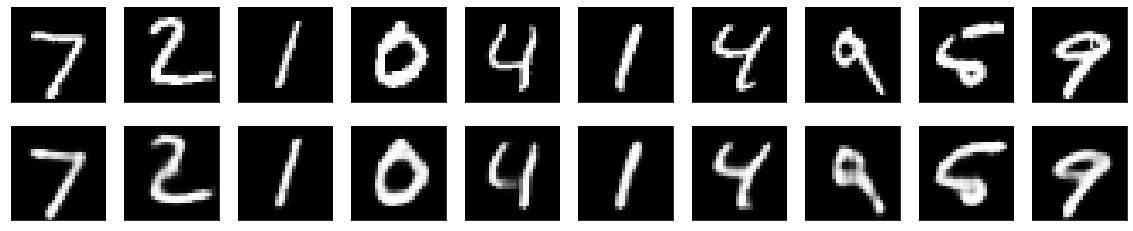

In [210]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [211]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [212]:
encoded_imgs = encoder.predict(x_test)
#decoded_imgs = decoder.predict(encoded_imgs)

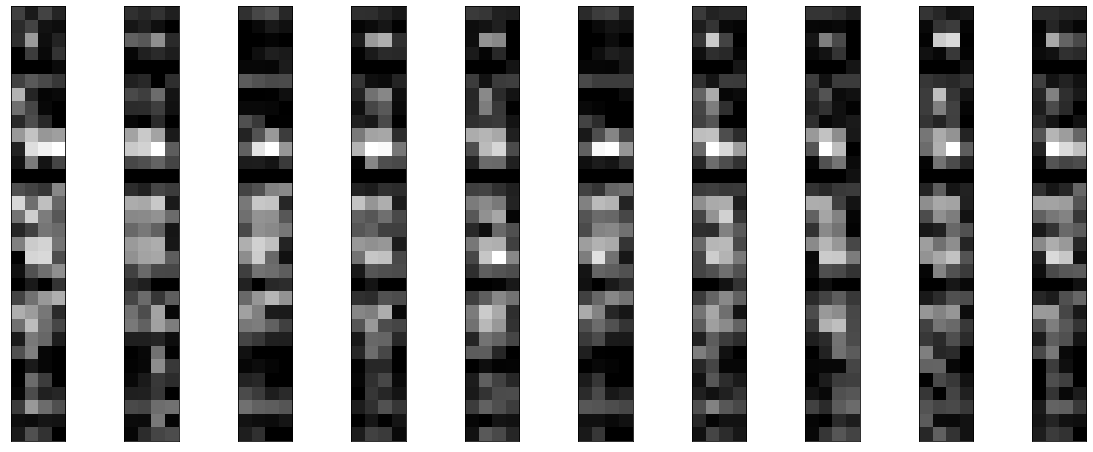

In [213]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Application to image denoising

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [214]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

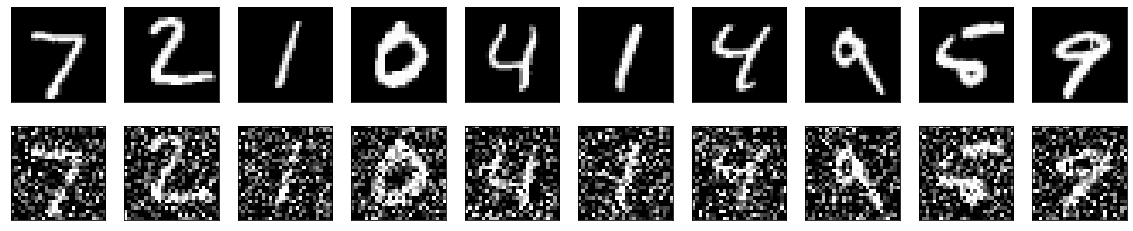

In [218]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [219]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [220]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1743 - val_loss: 0.1241
Epoch 2/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1190 - val_loss: 0.1114
Epoch 3/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1119 - val_loss: 0.1078
Epoch 4/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1085 - val_loss: 0.1052
Epoch 5/100
60000/60000 [==============================] - 66s 1ms/step - loss: 0.1061 - val_loss: 0.1027
Epoch 6/100
60000/60000 [==============================] - 66s 1ms/step - loss: 0.1044 - val_loss: 0.1020
Epoch 7/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1031 - val_loss: 0.1024
Epoch 8/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1022 - val_loss: 0.1018
Epoch 9/100
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1015 - val_loss: 0.1

60000/60000 [==============================] - 67s 1ms/step - loss: 0.0948 - val_loss: 0.0958
Epoch 78/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0947 - val_loss: 0.0947
Epoch 79/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0947 - val_loss: 0.0945
Epoch 80/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0946 - val_loss: 0.0940
Epoch 81/100
60000/60000 [==============================] - 66s 1ms/step - loss: 0.0946 - val_loss: 0.0940
Epoch 82/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0946 - val_loss: 0.0950
Epoch 83/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0947 - val_loss: 0.0940
Epoch 84/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0946 - val_loss: 0.0942
Epoch 85/100
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0945 - val_loss: 0.0944
Epoch 86/100
60000/60000 [========================

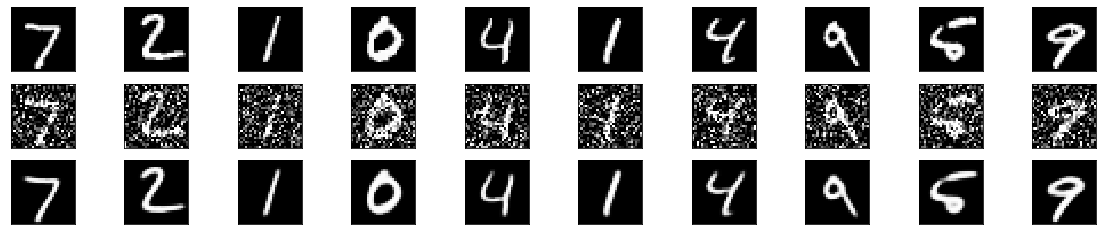

In [221]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + n+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It seems to work pretty well. If you scale this process to a bigger convnet, you can start building document denoising or audio denoising models

## Sequence-to-sequence autoencoder

If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

We won't be demonstrating that one on any specific dataset. We will just put a code example here for future reference for the reader!

In [ ]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

## Variational autoencoder (VAE)

Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

Step:
 1. mapping inputs to our latent distribution parameters
 2. use these parameters to sample new similar points from the latent space
 3. map these sampled latent points back to reconstructed inputs
 4. train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term

### How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

Step:
 1. mapping inputs to our latent distribution parameters
 2. use these parameters to sample new similar points from the latent space
 3. map these sampled latent points back to reconstructed inputs
 4. train the model using the end-to-end model, with a custom loss function: the sum of a reconstruction term, and the KL divergence regularization term

### VAE Encoder Example : MNIST

In [260]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### Create a sampling layer

In [259]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#### Build the encoder

In [252]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

#### Build the decoder

In [253]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

#### Define the VAE as a Model with a custom train_step

In [254]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

#### Train the VAE

In [255]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 41s 75ms/step - loss: 211.1813 - reconstruction_loss: 209.0057 - kl_loss: 2.1756
Epoch 2/30
547/547 [==============================] - 41s 75ms/step - loss: 188.3914 - reconstruction_loss: 185.9816 - kl_loss: 2.4098
Epoch 3/30
547/547 [==============================] - 41s 74ms/step - loss: 183.0816 - reconstruction_loss: 180.8708 - kl_loss: 2.2108
Epoch 4/30
547/547 [==============================] - 41s 75ms/step - loss: 167.3275 - reconstruction_loss: 163.9822 - kl_loss: 3.3453
Epoch 5/30
547/547 [==============================] - 41s 76ms/step - loss: 159.0655 - reconstruction_loss: 155.3182 - kl_loss: 3.7473
Epoch 6/30
547/547 [==============================] - 42s 76ms/step - loss: 156.0910 - reconstruction_loss: 152.2929 - kl_loss: 3.7980
Epoch 7/30
547/547 [==============================] - 40s 73ms/step - loss: 154.3820 - reconstruction_loss: 150.5542 - kl_loss: 3.8278
Epoch 8/30
547/547 [==============================] - 3

#### Display a grid of sampled digits

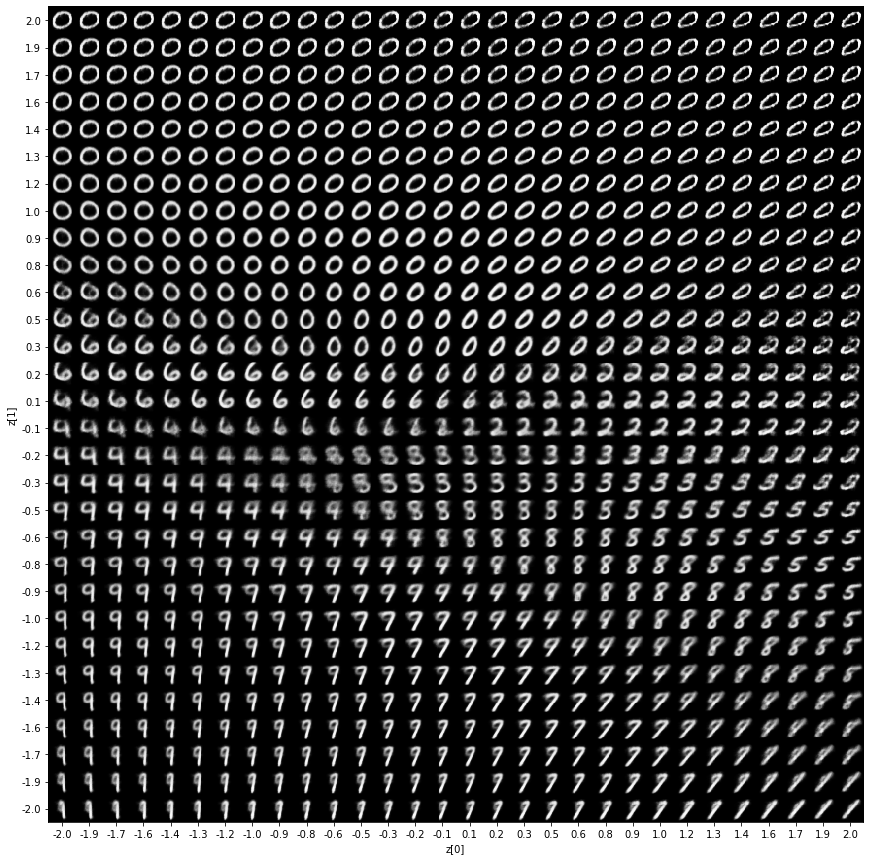

In [256]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

#### Display how the latent space clusters different digit classes

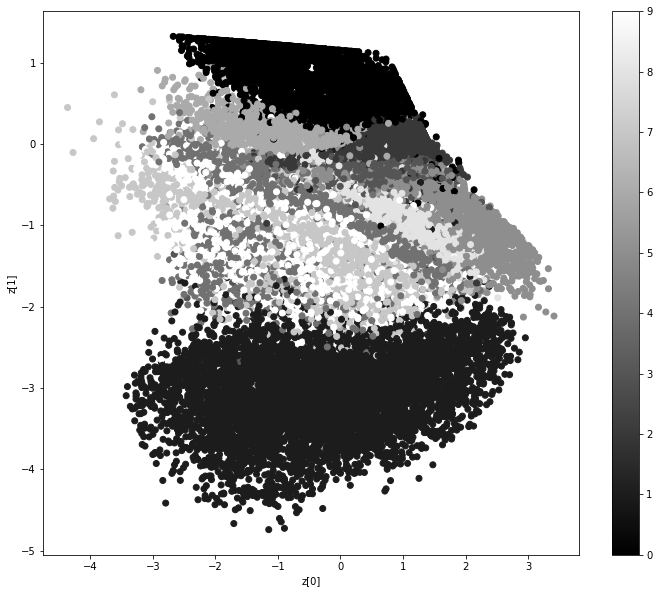

In [263]:

def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)

## Reference Links

https://blog.keras.io/building-autoencoders-in-keras.html
https://www.pyimagesearch.com/2020/02/24/denoising-autoencoders-with-keras-tensorflow-and-deep-learning/
https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html


